In [1]:
import numpy as np
import networkx as nx

In [2]:
TIME_HORIZON = 60*24 # minutes
EV_ENERGY_CONSUMPTION_RATE = 0.16 # kW/km
EV_MAX_BATTERY_CAPACITY = 54.75 # kWh
EVCS_CHARGING_EFFICIENCY = 0.9 # kW
CHARGING_POWER = 60 # kW
SEED = 42
np.random.seed(SEED)

In [3]:
uniform_arrivals = np.sort(np.random.uniform(360,1200,140).astype(int))

In [4]:
uniform_arrivals

array([ 364,  365,  377,  381,  386,  388,  397,  399,  408,  413,  414,
        422,  422,  424,  434,  442,  450,  452,  457,  460,  460,  462,
        477,  478,  491,  491,  495,  503,  512,  514,  515,  516,  524,
        526,  527,  538,  546,  551,  552,  569,  577,  587,  595,  603,
        604,  605,  615,  615,  621,  621,  624,  627,  631,  633,  633,
        637,  643,  659,  661,  665,  667,  674,  686,  704,  710,  718,
        719,  722,  729,  743,  756,  774,  775,  787,  789,  791,  795,
        796,  799,  800,  813,  815,  819,  831,  857,  862,  862,  864,
        870,  873,  883,  892,  894,  895,  916,  934,  950,  953,  954,
        959,  972,  972,  974,  994,  999, 1007, 1007, 1008, 1011, 1019,
       1033, 1035, 1038, 1038, 1039, 1044, 1047, 1056, 1059, 1083, 1085,
       1087, 1092, 1105, 1109, 1111, 1112, 1122, 1123, 1134, 1140, 1149,
       1152, 1157, 1158, 1171, 1174, 1174, 1176, 1188])

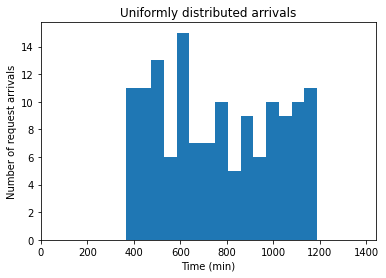

In [5]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(uniform_arrivals, 15, density=False)
plt.xlim([0, 1440])
plt.title("Uniformly distributed arrivals")
plt.ylabel("Number of request arrivals")
plt.xlabel("Time (min)")
plt.show()

## Simulate one episode

In [6]:
from modules.traffic_preprocess import TrafficPreprocessModule
from entities.evcs import ChargingStation
from entities.charging_request import ChargingRequest
from topologies.graph import Graph


In [7]:
def generate_random_node_pair(nodes_list):
    node_pair = []
    while len(node_pair) < 2:
        node_pair = np.random.choice(nodes_list, 2, replace=False)
    return node_pair

def load_topology(topology_dir):
    file = open(topology_dir, "rb")
    G = nx.read_edgelist(file)
    file.close()
    print(
        f'🏙️  Loaded topology with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')
    return G

In [16]:
last_request_time = 0

G = load_topology("topologies/santiago.edgelist")
G_utils = Graph(G)

TPM = TrafficPreprocessModule(G)
traffic_network = TPM.get_traffic_network()
nodes_labels = G_utils.get_nodes_labels(exclude_evcs=True)
evcs_labels = G_utils.get_evcs_labels()
print(f'{len(nodes_labels)} intersections with {len(evcs_labels)} EVCSs')
charging_stations = [ChargingStation(label, 0.5) for label in evcs_labels]
charging_requests = []
for t in range(TIME_HORIZON):
    if t in uniform_arrivals:
        # Generate a new request and add it to the queue
        node_pair = generate_random_node_pair(nodes_labels)
        delta_t = t - last_request_time
        initial_soc = np.random.uniform(0.2, 0.4)
        required_soc = 0.9
        last_request_time = t
        charging_requests.append(ChargingRequest(
            node_pair[0], node_pair[1], t, delta_t, initial_soc, required_soc))

        evcs_arrival_times = [t + TPM.get_total_time(
            node_pair[0], evcs_label) for evcs_label in evcs_labels]

        # array that contains total energy consumption from source node to each EVCS
        evcs_total_energy_consumption = EV_ENERGY_CONSUMPTION_RATE * \
            np.array([G_utils.get_total_distance(node_pair[0], evcs_label)
                     for evcs_label in evcs_labels])
        evcs_soc_arrival = initial_soc - \
            evcs_total_energy_consumption/EV_MAX_BATTERY_CAPACITY
        evcs_charging_energy_required = (
            required_soc - evcs_soc_arrival)*EV_MAX_BATTERY_CAPACITY
        evcs_charging_time_required = evcs_charging_energy_required / \
            (EVCS_CHARGING_EFFICIENCY*CHARGING_POWER)
        evcs_driving_times = np.array([TPM.get_total_time(
            node_pair[0], evcs_label) + TPM.get_total_time(evcs_label, node_pair[1]) for evcs_label in evcs_labels])
        evcs_total_driving_distance = np.array([G_utils.get_total_distance(
            node_pair[0], evcs_label) for evcs_label in evcs_labels])

        print("Arrival at {}, delta_t: {}, node pair: {}".format(
            t, delta_t, node_pair))
        print("Arrival times: {}".format(evcs_arrival_times))
        print("EVCS total energy consumption: {}".format( evcs_total_energy_consumption))
        print("EVCS SOC arrival: {}".format(evcs_soc_arrival))
        print("EVCS charging energy required: {}".format(evcs_charging_energy_required))
        print("EVCS charging time required: {}".format(evcs_charging_time_required))
        print("EVCS driving times: {}".format(evcs_driving_times))
        print("EVCS total driving distance: {}".format(evcs_total_driving_distance))
        print("EVCS total driving times: {}".format(evcs_driving_times))
        print("------------------------------------------------------------------------------")


🏙️  Loaded topology with 33 nodes and 49 edges.
25 intersections with 8 EVCSs
Arrival at 364, delta_t: 364, node pair: ['5' '12']
Arrival times: [389.79, 385.053, 372.382, 386.184, 367.24, 368.953, 366.986, 370.937]
EVCS total energy consumption: [4.1264  3.36848 1.34112 3.54944 0.5184  0.79248 0.47776 1.10992]
EVCS SOC arrival: [0.30107898 0.31492227 0.35195167 0.31161706 0.36697852 0.3619725
 0.36772081 0.3561745 ]
EVCS charging energy required: [32.79092586 32.03300586 30.00564586 32.21396586 29.18292586 29.45700586
 29.14228586 29.77444586]
EVCS charging time required: [0.60723937 0.59320381 0.55566011 0.59655492 0.54042455 0.54550011
 0.53967196 0.55137863]
EVCS driving times: [48.87  37.822 16.852 35.258 12.33  22.236 18.302 23.399]
EVCS total driving distance: [25.79  21.053  8.382 22.184  3.24   4.953  2.986  6.937]
EVCS total driving times: [48.87  37.822 16.852 35.258 12.33  22.236 18.302 23.399]
------------------------------------------------------------------------------
A

## Environment implementation

In [11]:
import gym
from gym import spaces
import numpy as np


In [12]:
G = load_topology("topologies/santiago.edgelist")

🏙️  Loaded topology with 33 nodes and 49 edges.


In [17]:
class RouteChargingStationEnv(gym.Env):
    def __init__(self, G, request_times):
        self.G = G
        self.G_utils = Graph(G)
        self.TPM = TrafficPreprocessModule(G)
        self.traffic_network = self.TPM.get_traffic_network()
        self.nodes_labels = self.G_utils.get_nodes_labels(exclude_evcs=True)
        self.evcs_labels = self.G_utils.get_evcs_labels()
        self.charging_stations = [ChargingStation(label, 0.5) for label in self.evcs_labels]
        self.charging_requests = []
        self.last_request_time = 0
        self.uniform_arrivals = np.sort(np.random.uniform(360,1200,80).astype(int))
        # 1D observation space in interval -inf to +inf
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        # Discrete action (index of EVCS)
        self.action_space = spaces.Discrete(len(self.evcs_labels))        
    